# Graficador de resultados

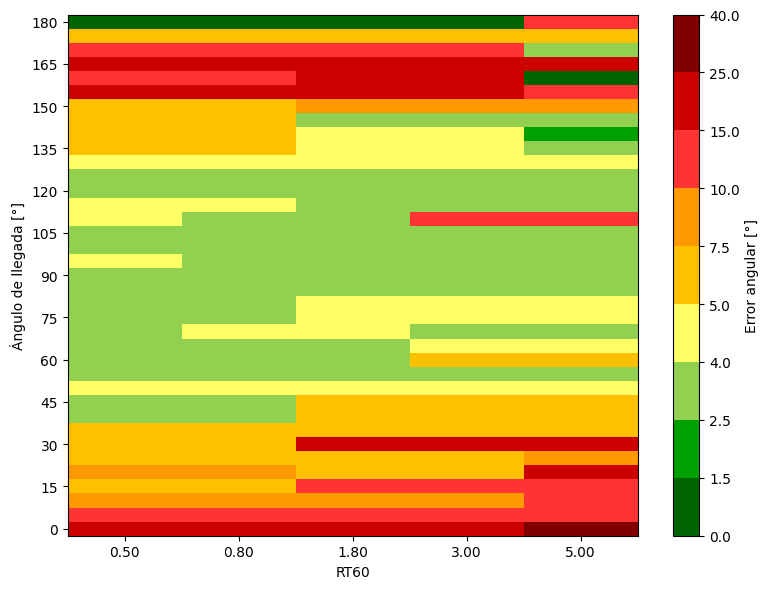

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap, BoundaryNorm

# === CONFIGURACIONES ===
measure = "sweep"         # Puede ser: "angle_error", "snr_db", etc.
method_graph = "phat"
x_variable = "rt60"           # Ej: "rt60_num", "snr_db", "dist_source"
x_lim = (0.5, 5.0)                # Limite eje x (solo para interpolated)
modo_grafico = "grid"     # "grid" o "interpolated"

# === ETIQUETAS DEL EJE X (con unidades) ===
x_labels = {
    "rt60_num": "RT60 [s]",
    "snr_db": "SNR [dB]",
    "dist_source": "DISTANCIA [m]",
    "angle": "ÁNGULO [°]"
}

# === PALETA DE COLORES PERSONALIZADA ===
boundaries = [0, 1.5, 2.5, 4, 5, 7.5, 10, 15, 25, 40]
colors = [
    "#006400", "#00a000", "#92d050", "#ffff66", "#ffc000",
    "#ff9900", "#ff3333", "#cc0000", "#800000"
]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, len(colors), clip=True)

# === MAPAS RT60 ===
rt60_map = {
    "very_short": "0.5 s", "short": "0.8 s", "medium": "1.8 s",
    "long": "3 s", "very_long": "5 s"
}
rt60_numeric = {v: float(v[:-2]) for v in rt60_map.values()}

# === CARGA DE DATOS ===
csv_folder = "csv_results"
pattern = os.path.join(csv_folder, "sweep_0_180_5_*.csv")
archivos = glob.glob(pattern)
if not archivos:
    raise FileNotFoundError("No se encontraron archivos")

dfs = []
for archivo in archivos:
    match = re.search(r"sweep_0_180_5_(.*?)_rev_(.*)\.csv", archivo)
    if match:
        reverb_key = match.group(1).lower()
        metodo = match.group(2).upper()
        rt60_val = rt60_map.get(reverb_key, "?")
        df_tmp = pd.read_csv(archivo)
        df_tmp["method"] = metodo
        df_tmp["rt60_val"] = rt60_val
        dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True)
df["rt60_num"] = df["rt60_val"].map(rt60_numeric)
df = df[df["method"].str.lower() == method_graph.lower()]

# === VALIDAR VARIABLE X ===
if x_variable not in df.columns:
    raise ValueError(f"La columna '{x_variable}' no está en el DataFrame.")
if not np.issubdtype(df[x_variable].dtype, np.number):
    try:
        df[x_variable] = pd.to_numeric(df[x_variable])
    except Exception:
        raise TypeError(f"No se pudo convertir '{x_variable}' a tipo numérico.")

# === GRAFICADO ===
plt.figure(figsize=(8, 6))
x_label = x_labels.get(x_variable, x_variable.upper())

if modo_grafico == "interpolated":
    angle_vals = np.linspace(0, 180, 500)
    x_vals = np.linspace(x_lim[0], x_lim[1], 400)
    X, A = np.meshgrid(x_vals, angle_vals)

    points = df[["angle", x_variable]].values
    values = df["angle_error"].values
    Z = griddata(points, values, (A, X), method="linear")
    Z_masked = np.ma.masked_invalid(Z)

    heatmap = plt.contourf(
        X, A, Z_masked,
        levels=boundaries, cmap=cmap, norm=norm, extend="max"
    )

    plt.xlabel(x_label)
    plt.ylabel("Ángulo de llegada [°]")
    plt.xlim(x_lim)
    plt.gca().invert_yaxis()

elif modo_grafico == "grid":
    df["angle_round"] = df["angle"].round(1)
    df["x_round"] = df[x_variable].round(2)

    pivot = df.pivot_table(
        index="angle_round",
        columns="x_round",
        values="angle_error"
    ).sort_index(ascending=False)

    ny, nx = pivot.shape
    x = np.arange(nx + 1)
    y = np.arange(ny + 1)

    pc = plt.pcolormesh(x, y, pivot.values, cmap=cmap, norm=norm, shading="auto")

    xticks = np.arange(0.5, nx + 0.5)
    xlabels = [f"{val:.2f}" for val in pivot.columns]
    step = max(1, ny // 10)
    yticks = np.arange(0.5, ny + 0.5, step)
    ylabels = [f"{val:.0f}" for val in pivot.index[::step]]

    plt.xticks(ticks=xticks, labels=xlabels)
    plt.yticks(ticks=yticks, labels=ylabels)

    heatmap = pc

    plt.xlabel(x_label)
    plt.ylabel("Ángulo de llegada [°]")
    plt.gca().invert_yaxis()

else:
    raise ValueError("Modo gráfico no reconocido. Use 'grid' o 'interpolated'.")

# === BARRA DE COLOR Y GUARDADO ===
cbar = plt.colorbar(heatmap, ticks=boundaries)
cbar.set_label("Error angular [°]")

os.makedirs("figuras_heatmaps", exist_ok=True)
plt.tight_layout()
plt.savefig(f"figuras_heatmaps/{measure}_heatmap_{modo_grafico}_{method_graph}.png", dpi=300)
plt.show()


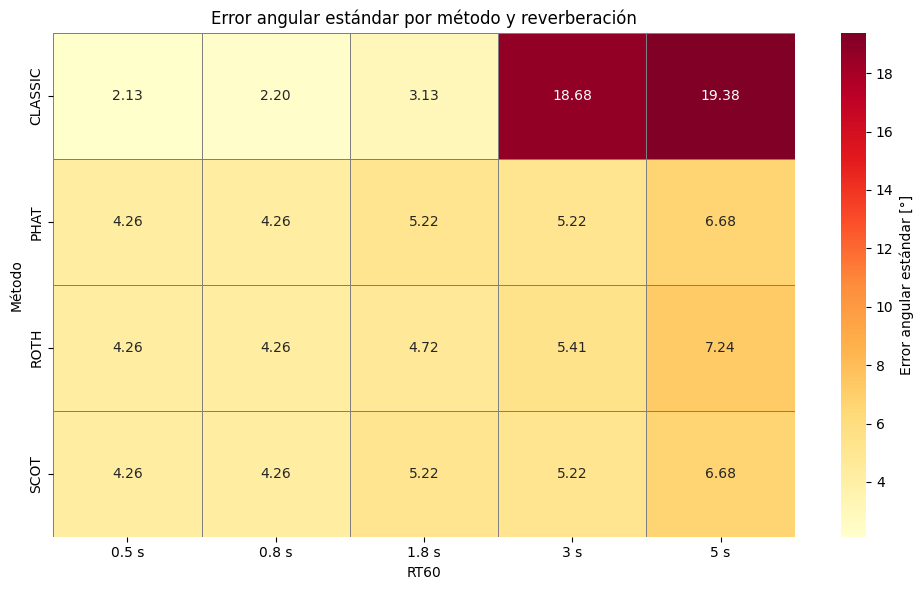

In [ ]:
# No me convence del todo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import os

# === CONFIGURACIÓN GENERAL ===
csv_folder = "csv_results"
method_col = "method"
rt60_col = "rt60_val"
angle_error_col = "angle_error"
output_file = "figuras_heatmaps/heatmap_std_por_metodo_y_rt60.png"

# === MAPAS DE RT60 ===
rt60_map = {
    "very_short": "0.5 s", "short": "0.8 s", "medium": "1.8 s",
    "long": "3 s", "very_long": "5 s"
}
rt60_numeric = {v: float(v[:-2]) for v in rt60_map.values()}

# === CARGA DE DATOS ===
pattern = os.path.join(csv_folder, "sweep_0_180_5_*.csv")
archivos = glob.glob(pattern)
if not archivos:
    raise FileNotFoundError("No se encontraron archivos en el directorio")

dfs = []
for archivo in archivos:
    match = re.search(r"sweep_0_180_5_(.*?)_rev_(.*)\.csv", archivo)
    if match:
        reverb_key = match.group(1).lower()
        metodo = match.group(2).upper()
        rt60_val = rt60_map.get(reverb_key, "?")
        df_tmp = pd.read_csv(archivo)
        df_tmp[method_col] = metodo
        df_tmp[rt60_col] = rt60_val
        df_tmp["rt60_num"] = rt60_numeric.get(rt60_val, np.nan)
        dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True)

# === AGRUPACIÓN Y CÁLCULO DE ERROR ESTÁNDAR ===
pivot_std = df.groupby([method_col, rt60_col])[angle_error_col].std().reset_index()
pivot_tabla = pivot_std.pivot(index=method_col, columns=rt60_col, values=angle_error_col)

# Ordenar columnas según valor numérico real
ordered_cols = sorted(pivot_tabla.columns, key=lambda x: rt60_numeric.get(x, np.inf))
pivot_tabla = pivot_tabla[ordered_cols]

# === HEATMAP ===
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_tabla,
    annot=True, fmt=".2f",
    cmap="YlOrRd", linewidths=0.5, linecolor='gray',
    cbar_kws={"label": "Error angular estándar [°]"}
)

plt.title("Error angular estándar por método y reverberación")
plt.xlabel("RT60")
plt.ylabel("Método")
plt.tight_layout()

os.makedirs("figuras_heatmaps", exist_ok=True)
plt.savefig(output_file, dpi=300)
plt.show()


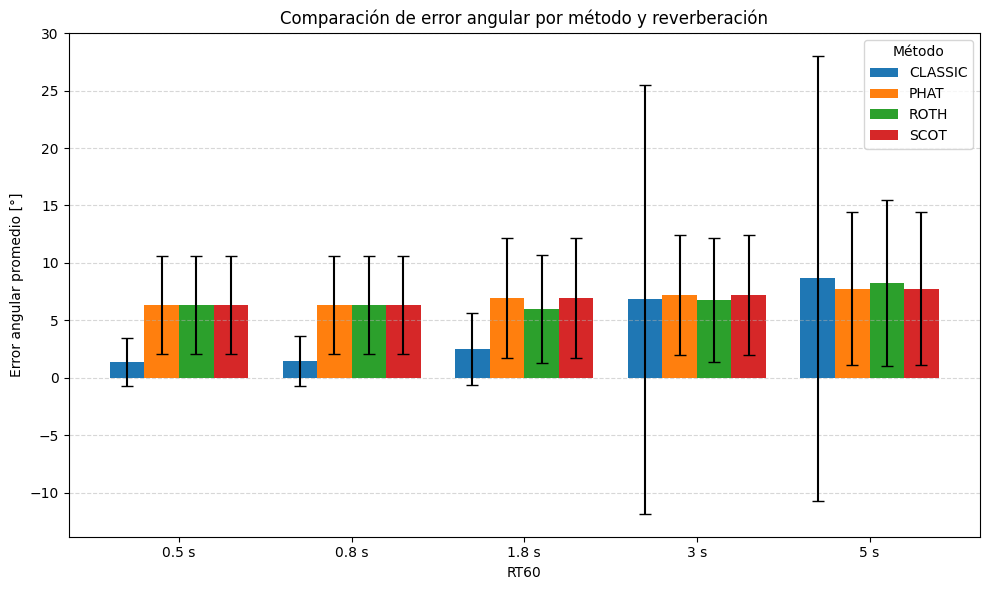

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os

# === MAPEO RT60 ===
rt60_map = {
    "very_short": "0.5 s", "short": "0.8 s", "medium": "1.8 s",
    "long": "3 s", "very_long": "5 s"
}
rt60_numeric = {v: float(v[:-2]) for v in rt60_map.values()}

# === CARGA DE DATOS ===
csv_folder = "csv_results"
pattern = os.path.join(csv_folder, "sweep_0_180_5_*.csv")
archivos = glob.glob(pattern)

dfs = []
for archivo in archivos:
    match = re.search(r"sweep_0_180_5_(.*?)_rev_(.*)\.csv", archivo)
    if match:
        reverb_key = match.group(1).lower()
        metodo = match.group(2).upper()
        rt60_val = rt60_map.get(reverb_key, "?")
        df_tmp = pd.read_csv(archivo)
        df_tmp["method"] = metodo
        df_tmp["rt60_val"] = rt60_val
        dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True)

# === AGRUPACIÓN POR MÉTODO Y RT60 ===
grouped = df.groupby(["method", "rt60_val"])["angle_error"]
mean_error = grouped.mean().unstack()
std_error = grouped.std().unstack()

# === ORDEN PERSONALIZADO PARA EJE X ===
rt60_ordenado = sorted(mean_error.columns, key=lambda x: rt60_numeric.get(x, float('inf')))

# === PARÁMETROS PARA BARRAS AGRUPADAS ===
metodos = mean_error.index.tolist()
x = np.arange(len(rt60_ordenado))
bar_width = 0.8 / len(metodos)  # repartir espacio entre métodos

plt.figure(figsize=(10, 6))

for i, metodo in enumerate(metodos):
    means = mean_error.loc[metodo, rt60_ordenado]
    stds = std_error.loc[metodo, rt60_ordenado]
    plt.bar(x + i * bar_width, means, yerr=stds, width=bar_width, capsize=4, label=metodo)

# === ESTÉTICA ===
plt.xticks(x + bar_width * (len(metodos) - 1) / 2, rt60_ordenado)
plt.xlabel("RT60")
plt.ylabel("Error angular promedio [°]")
plt.title("Comparación de error angular por método y reverberación")
plt.legend(title="Método")
plt.grid(axis='y', linestyle='--', alpha=0.5)

os.makedirs("figuras_heatmaps", exist_ok=True)
plt.tight_layout()
plt.savefig("figuras_heatmaps/errores_barras_con_std_por_metodo.png", dpi=300)
plt.show()


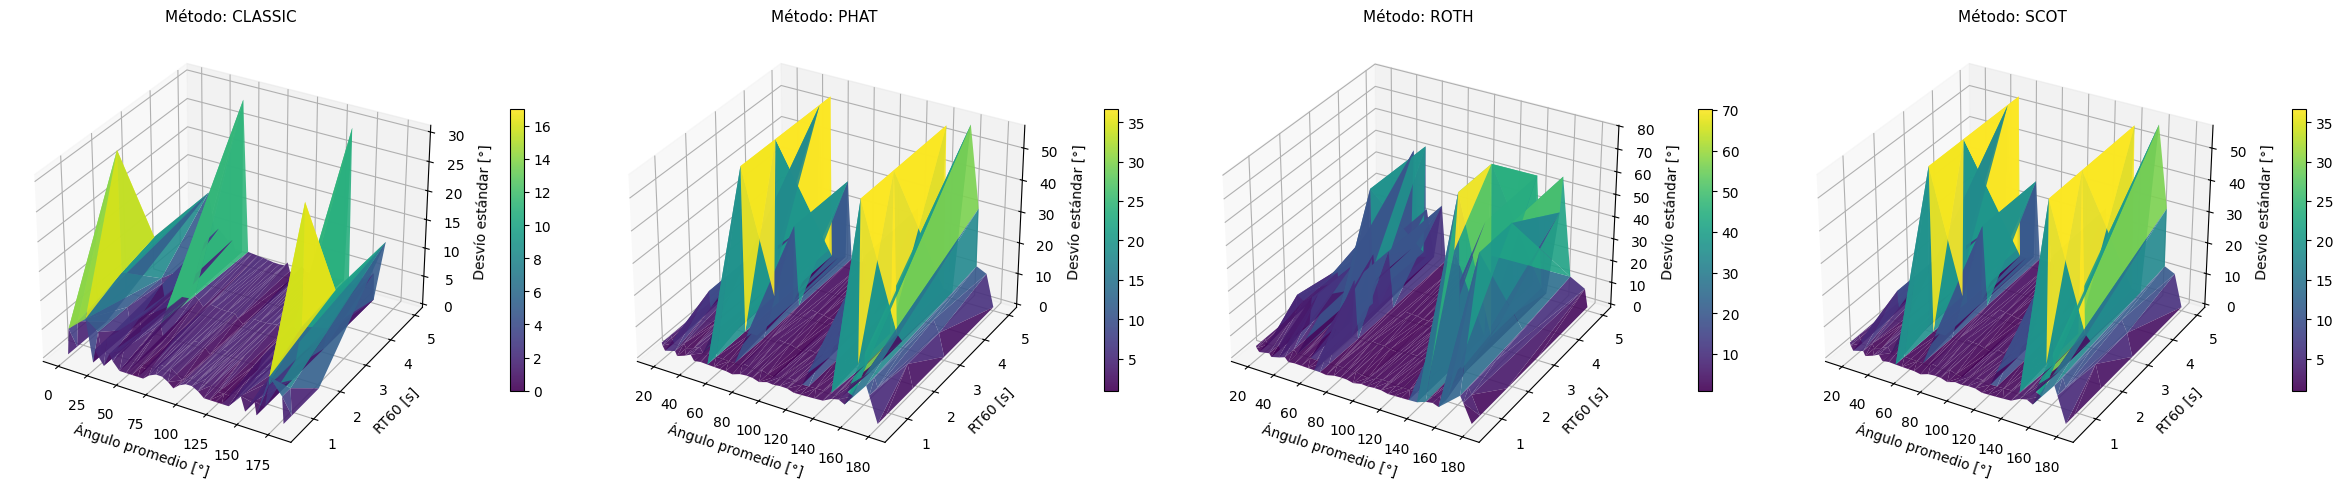

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import re
import os

# === MAPEO RT60 ===
rt60_map = {
    "very_short": "0.5 s", "short": "0.8 s", "medium": "1.8 s",
    "long": "3 s", "very_long": "5 s"
}
rt60_numeric = {v: float(v[:-2]) for v in rt60_map.values()}

# === CARGA DE DATOS ===
csv_folder = "csv_results"
pattern = os.path.join(csv_folder, "sweep_0_180_5_*.csv")
archivos = glob.glob(pattern)
if not archivos:
    raise FileNotFoundError("No se encontraron archivos en la carpeta.")

dfs = []
for archivo in archivos:
    match = re.search(r"sweep_0_180_5_(.*?)_rev_(.*)\.csv", archivo)
    if match:
        reverb_key = match.group(1).lower()
        metodo = match.group(2).upper()
        rt60_val = rt60_map.get(reverb_key, "?")
        df_tmp = pd.read_csv(archivo)
        df_tmp["method"] = metodo
        df_tmp["rt60_val"] = rt60_val
        df_tmp["rt60_num"] = rt60_numeric.get(rt60_val, np.nan)
        dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True)

# === DATOS NECESARIOS PARA EL 3D ===
# Solo tomamos filas que tienen los datos necesarios
df_valid = df.dropna(subset=["avg_angle", "rt60_num", "desv_std_angle"])
metodos = df_valid["method"].unique()
n_metodos = len(metodos)

# === FIGURA MULTIPANEL 3D ===
fig = plt.figure(figsize=(6 * n_metodos, 5))
for i, metodo in enumerate(metodos, 1):
    df_met = df_valid[df_valid["method"] == metodo]

    ax = fig.add_subplot(1, n_metodos, i, projection="3d")
    X = df_met["avg_angle"]
    Y = df_met["rt60_num"]
    Z = df_met["desv_std_angle"]

    surf = ax.plot_trisurf(X, Y, Z, cmap="viridis", edgecolor="none", alpha=0.9)
    ax.set_title(f"Método: {metodo}", fontsize=11)
    ax.set_xlabel("Ángulo promedio [°]")
    ax.set_ylabel("RT60 [s]")
    ax.set_zlabel("Desvío estándar [°]")
    ax.view_init(elev=30, azim=-60)
    fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1)

# === GUARDAR FIGURA ===
os.makedirs("figuras_surface", exist_ok=True)
plt.tight_layout()
plt.savefig("figuras_surface/surface_desv_std_por_metodo.png", dpi=300)
plt.show()


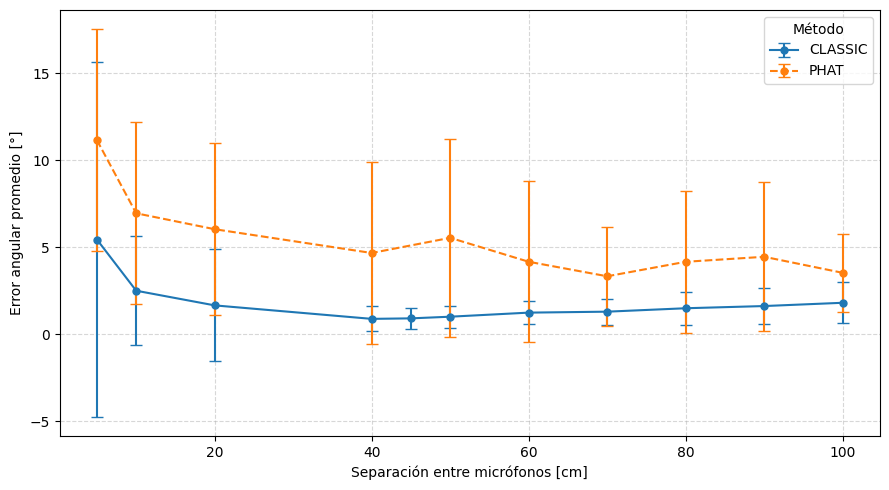

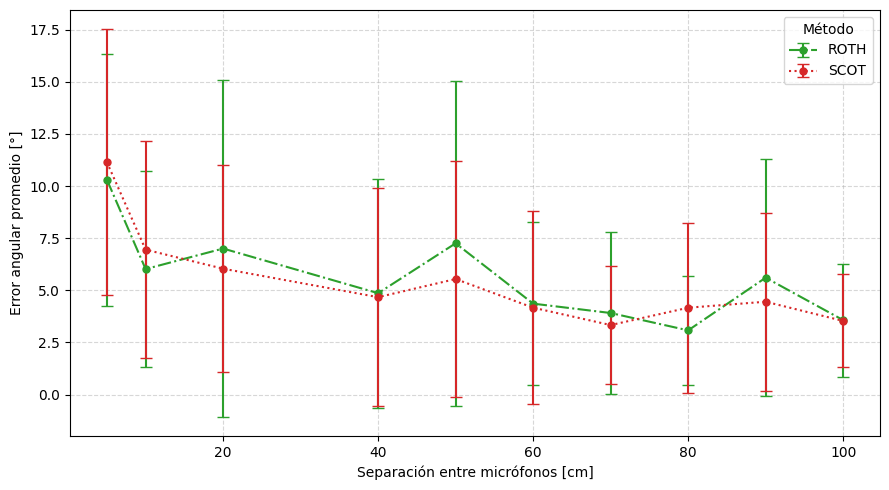

In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os

# === CONFIGURACIÓN ===
csv_folder = "csv_results"
pattern = os.path.join(csv_folder, "sweep_medium_rev_*_mic_*.csv")

# === CARGA DE DATOS ===
archivos = glob.glob(pattern)
if not archivos:
    raise FileNotFoundError("No se encontraron archivos en la carpeta 'csv_results'.")

datos = []
for archivo in archivos:
    match = re.search(r"rev_(\d+)(cm|m)_mic_(.*?)\.csv", archivo)
    if match:
        valor = int(match.group(1))
        unidad = match.group(2)
        metodo = match.group(3).upper()

        # Convertir a cm
        distancia_cm = valor if unidad == "cm" else valor * 100

        df_tmp = pd.read_csv(archivo)
        error_medio = df_tmp["angle_error"].mean()
        error_std = df_tmp["angle_error"].std()

        datos.append({
            "distancia_cm": distancia_cm,
            "method": metodo,
            "error_promedio": error_medio,
            "error_std": error_std
        })

df_plot = pd.DataFrame(datos)

# === ESTÉTICA DE TRAZOS Y COLORES ===
colores = {
    "CLASSIC": "tab:blue",
    "PHAT": "tab:orange",
    "ROTH": "tab:green",
    "SCOT": "tab:red"
}
trazos = {
    "CLASSIC": "-",
    "PHAT": "--",
    "ROTH": "-.",
    "SCOT": ":"
}

# === FUNCION DE TRAZADO GENERAL ===
def graficar_metodos(metodos, nombre_archivo):
    plt.figure(figsize=(9, 5))
    for metodo in metodos:
        df_met = df_plot[df_plot["method"] == metodo].sort_values("distancia_cm")
        plt.errorbar(
            df_met["distancia_cm"],
            df_met["error_promedio"],
            yerr=df_met["error_std"],
            label=metodo,
            fmt='o',
            linestyle=trazos.get(metodo, "-"),
            color=colores.get(metodo, None),
            capsize=4,
            linewidth=1.5,
            markersize=5
        )

    plt.xlabel("Separación entre micrófonos [cm]")
    plt.ylabel("Error angular promedio [°]")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Método", loc="upper right")
    plt.tight_layout()
    
    os.makedirs("figuras_distancia", exist_ok=True)
    plt.savefig(f"figuras_distancia/{nombre_archivo}.png", dpi=300)
    plt.show()

# === GRAFICAR AMBOS GRUPOS ===
graficar_metodos(["CLASSIC", "PHAT"], "error_vs_distancia_classic_phat")
graficar_metodos(["ROTH", "SCOT"], "error_vs_distancia_roth_scot")


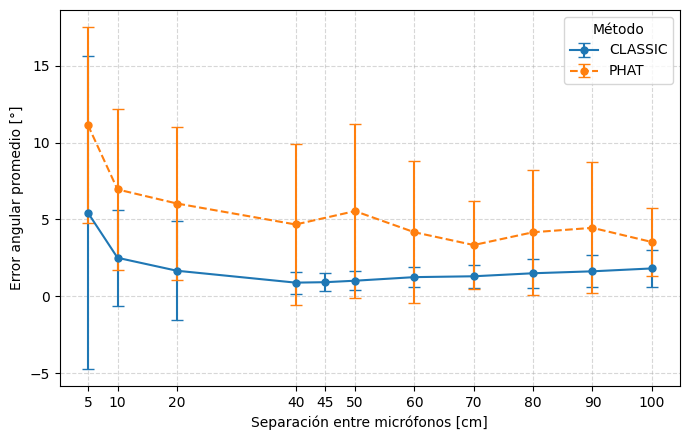

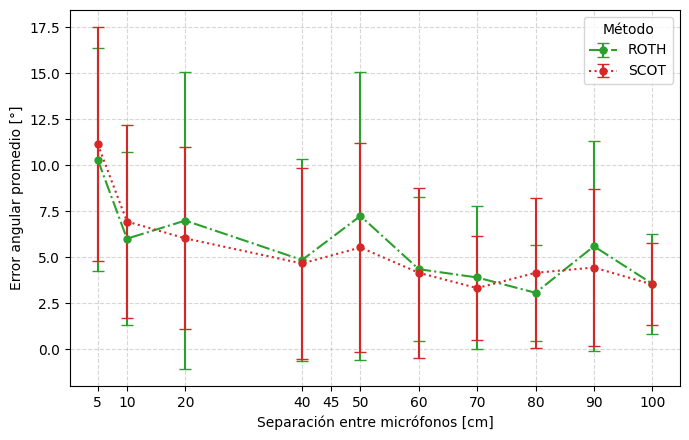

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os

# === CONFIGURACIÓN ===
csv_folder = "csv_results"
pattern = os.path.join(csv_folder, "sweep_medium_rev_*_mic_*.csv")

# === CARGA DE DATOS ===
archivos = glob.glob(pattern)
if not archivos:
    raise FileNotFoundError("No se encontraron archivos en la carpeta 'csv_results'.")

datos = []
for archivo in archivos:
    match = re.search(r"sweep_medium_rev_.*_mic_(.*?)\.csv", archivo)
    if match:
        metodo = match.group(1).upper()

        df_tmp = pd.read_csv(archivo)
        distancia_cm = df_tmp["mic_d"].iloc[0] * 100  # Convertimos de metros a cm
        error_medio = df_tmp["angle_error"].mean()
        error_std = df_tmp["angle_error"].std()

        datos.append({
            "distancia_cm": distancia_cm,
            "method": metodo,
            "error_promedio": error_medio,
            "error_std": error_std
        })

df_plot = pd.DataFrame(datos)

# === ESTILOS POR MÉTODO ===
colores = {
    "CLASSIC": "tab:blue",
    "PHAT": "tab:orange",
    "ROTH": "tab:green",
    "SCOT": "tab:red"
}
trazos = {
    "CLASSIC": "-",
    "PHAT": "--",
    "ROTH": "-.",
    "SCOT": ":"
}

# === FUNCIÓN PARA GRAFICAR GRUPOS DE MÉTODOS ===
def graficar_metodos(metodos, nombre_archivo):
    plt.figure(figsize=(7, 4.5))

    xticks = sorted(df_plot["distancia_cm"].unique())

    for metodo in metodos:
        df_met = df_plot[df_plot["method"] == metodo].sort_values("distancia_cm")
        plt.errorbar(
            df_met["distancia_cm"],
            df_met["error_promedio"],
            yerr=df_met["error_std"],
            label=metodo,
            fmt='o',
            linestyle=trazos.get(metodo, "-"),
            color=colores.get(metodo, None),
            capsize=4,
            linewidth=1.5,
            markersize=5
        )

    plt.xlabel("Separación entre micrófonos [cm]")
    plt.ylabel("Error angular promedio [°]")
    plt.xticks(xticks)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Método", loc="upper right")
    plt.tight_layout()

    os.makedirs("figuras_distancia", exist_ok=True)
    plt.savefig(f"figuras_distancia/{nombre_archivo}.png", dpi=300)
    plt.show()

# === GRAFICAR LOS DOS GRUPOS SEPARADOS ===
graficar_metodos(["CLASSIC", "PHAT"], "error_vs_distancia_classic_phat")
graficar_metodos(["ROTH", "SCOT"], "error_vs_distancia_roth_scot")
